# Homogeneisation - Visco-elastic materials

### TODO : Description du notebook 

---

## I- Importation des classes et des modules utiles

In [1]:
!pip install ipywidgets # Installation du package permettant la gestion des widgets
from IPython.display import clear_output, display
clear_output()
print("Package downloaded")

Package downloaded


In [2]:
import ipywidgets as widgets
from classes_visco import *
from os import listdir
import pandas as pd

In [3]:
print("Modèles importés : {}".format(list_models))

Modèles importés : [<class 'classes_visco.Mori_Tanaka'>, <class 'classes_visco.Eshelby_Approximation'>, <class 'classes_visco.Differential_Scheme'>]


--- 

## II- Fonctions utiles

In [4]:
parameters_name = {
    'K': 'Bulk modulus K',
    'G': 'Shear modulus G',
    'E': 'Young modulus E',
    'nu': "Poisson's ratio " + r'\(\nu\)',
    "G'": "Storage modulus G'",
    "G''": "Loss modulus G''",
}
parameters_name_bis = {value: key for (key, value) in parameters_name.items()}
input_folder = "inputs/viscoelastic_behaviors" # Dossier contenant les comportements visco-élastiques

def gen_tab_behavior():
    """
    Routine qui génère un widget de type 'tab' permettant le choix des paramètres associés aux comportements. 
    Chaque onglet généré correspond à un comportement du dictionnaire 'dict_behaviors' implémenté dans 'classes.py'.
    La fonction renvoie :
    - une liste de liste de widgets (list_widgets) contenant autant de listes que d'onglet. Chaque liste contient les widgets générant les paramètres asssociés au comportement 
    de l'onglet correspondant.
    - un widget tab correspondant au résultat final à afficher.    
    """
    behaviors_str = list(dict_behaviors.keys()) # Liste des noms des comportements déjà implémentés, définis dans classes.py
    list_widgets = [] # Liste de liste, chaque liste correspond à un onglet du tab et contient les widgets de cet onglet non formatés
    tab_titles = [] # Nom des onglets, chaque onglet est associé à un type de comportement
    # Construction des widgets associés à chaque onglet
    for behavior_str in behaviors_str:
        widgets_onglet = []
        parameters = dict_behaviors[behavior_str] # Paramètres associés au comportement (exemple : ['K', 'G'] pour Isotropic)
        for parameter in parameters:
            w = widgets.FloatSlider(value=1, min=0.01, max=1000, step=0.01) # Widget associé au paramètre parameter
            if parameter == 'nu':
                w.max = 0.49
                w.value = 0.3
            # Traitement des paramètres visco-élastiques
            if parameter in ["G'", "G''"]:
                # TODO: expliquer le format attendu
                # Récupération de la liste des fichiers de comportement disponibles
                behavior_files = listdir(input_folder)
                # Sélection des fichiers .txt et .csv seuls
                behavior_files = [file for file in behavior_files if (file.endswith('.txt') or file.endswith('.csv'))]
                # Création du widget
                w = widgets.Dropdown(options=behavior_files)
            w_label = widgets.Label(value=parameters_name[parameter])
            widgets_onglet.append(widgets.HBox([w_label, w]))
        list_widgets.append(widgets_onglet)
        tab_titles.append(behavior_str)
    # Création du tab
    tab = widgets.Tab()
    tab.children = [widgets.VBox(w) for w in list_widgets]
    for pos, title in enumerate(tab_titles):
        tab.set_title(pos, title)
    return list_widgets, tab

def read_behavior(tab, list_widgets):
    """
    Fonction qui, à partir d'un widget 'tab' comme celui construit par la fonction précédente, renvoie le dictionnaire 'behavior' construit par l'utilisateur.
    Dans le cas d'un comportement viso-élastique, renvoie une liste de fréquences/températures notée frequency.
    Les valeurs du dict behavior sont alors des listes.
    """
    global input_folder
    behavior_int = tab.selected_index # Onglet ouvert par l'utilisateur
    widgets_parameters = list_widgets[behavior_int] # Widgets des paramètres de l'onglet ouvert
    if behavior_int != 2:
        # Cas élastique classique
        frequency = [] # Les paramètres sont idépendants de la fréquence/température
        behavior = {parameters_name_bis[w.children[0].value]: w.children[1].value for w in widgets_parameters}
    else:
        # Cas visco-élastique
        behavior = {}
        for w in widgets_parameters:
            parameter_name = parameters_name_bis[w.children[0].value] # Lecture du nom du paramètre (ex: 'K', "G'")
            if parameter_name == 'K':
                behavior['K'] = w.children[1].value # Valeur du widget FloatSlider associé
            else:
                # Cas de G' et G"
                filename = input_folder + '/' + w.children[1].value # Fichier choisi par l'utilisateur
                # Lecture du fichier
                parameter_values = [] # Liste de tuples (frequency, value)
                with open(filename, 'r') as file:
                    lines = file.readlines()
                    for line in lines:
                        line = line.strip().split()
                        line = [float(element) for element in line]
                        f, value = line
                        parameter_values.append((f, value))
                # Tri des valeurs par fréquence croissante
                parameter_values.sort()
                # Extraction des listes frequency et behavior
                frequency = [element[0] for element in parameter_values]
                behavior[parameter_name] = [element[1] for element in parameter_values]
    return behavior, frequency

def gen_tab_type():
    """
    Routine qui génère un widget de type 'tab' permettant le choix des paramètres associés aux types d'inclusions (aspect ratio, orientation, etc..). 
    TODO : Inclure l'orientation
    Chaque onglet généré correspond à un type du dictionnaire 'dict_types' implémenté dans 'classes.py'.
    La fonction renvoie :
    - une liste de liste de widgets (list_widgets) contenant autant de listes que d'onglets. Chaque liste contient les widgets générant les paramètres asssociés au comportement 
    de l'onglet correspondant.
    - un widget tab correspondant au résultat final à afficher.    
    """
    list_widgets = [] # Liste de listes, chaque liste correspond à un onglet et contient les widgets de cet onglet
    # Construction des widgets associés à chaque onglet
    for type_int in dict_types.keys():
        if type_int == 0:
            # Sphères, pas besoin de paramètres supllémentaires
            list_widgets.append([])
        elif type_int == 1:
            # Oblate
            w_label = widgets.Label(value="Aspect ratio")
            w_aspect_ratio = widgets.FloatSlider(min=0.01, max=0.99, step=0.01, value=0.5)
            list_widgets.append([w_label, w_aspect_ratio])
        elif type_int == 2:
            # Prolate
            w_label = widgets.Label(value="Aspect ratio")
            w_aspect_ratio = widgets.FloatSlider(min=1.01, max=10, step=0.01, value=1.5)
            list_widgets.append([w_label, w_aspect_ratio])
    # Création du tab
    tab = widgets.Tab()
    # Attribution des onglets
    tab.children = [widgets.HBox(w) for w in list_widgets]
    # Attribution des noms des onglets
    for pos, title in dict_types.items():
        tab.set_title(pos, title)
    return list_widgets, tab         

def read_type(tab, list_widgets):
    """
    Fonction qui, à partir d'un widget 'tab' comme celui construit par la fonction gen_tab_type, renvoie le type d'inclusion et le rapport d'apsect.
    """
    type_int = tab.selected_index # Onglet ouvert par l'utilisateur
    widgets_parameters = list_widgets[type_int]
    try:
        aspect_ratio = widgets_parameters[1].value
    except:
        # Il n'y a pas de rapport de forme, cas des sphères par exemple
        aspect_ratio = 1
    return type_int, aspect_ratio

def str_to_model(model_name):
    """
    Fonction qui renvoie l'instance de classe Model associée au nom de classe model_name (str).
    """
    for Model in list_models:
        model = Model()
        if model.name.upper() == model_name.upper():
            return model
        
def incr(value, value_incr, mini, maxi):
    """
    Incrémente la valeur de la variable value si celle-ci ne dépasse pas les bornes maxi et mini. 
    Renvoie un booléen qui indique si la variable a été incrémentée ou non (c'est le cas lorsque la variable est en dehors des bornes min max)
    """
    result = value
    result += value_incr
    if result > maxi:
        result = maxi
    if result < mini:
        result = mini
    changed = (result != value)
    return result, changed

---

## III- Calcul de comportement homogénéisé de microstructures
Cette section permet la génération manuelle de microstructure et le calcul de comportement homogénéisé avec les modèles disponibles.

In [5]:
dict_inclusions = {}
# Initialise la liste des inclusions créees. dict_inclusions est sous la forme {nam_inclusion (str): inclusion (Inclusion)}

### Construction d'une inclusion

In [6]:
# Nom de l'inclusion
w_label = widgets.Label(value='Inclusion name')
n_inclusion = 0 # Identifiant servant à donner automatiquement un nom unique à chaque inclusion
w_name = widgets.Text(value='inclusion '+str(n_inclusion))
display(w_label, w_name)

# Type d'inclusion
display(widgets.Label(value='Inclusion type'))
widgets_type, tab_type = gen_tab_type() # Génération du widgets tab de choix du type d'inclusion
display(tab_type)

# Comportement de l'inclusion
caption = widgets.Label(value='Inclusion behavior')
display(caption)
list_widgets, tab = gen_tab_behavior()
display(tab)

# Génération de l'inclusion
button_generate_inclusion = widgets.Button(description="Generate Inclusion")
output = widgets.Output()
display(button_generate_inclusion, output)
def generate_inclusion(b):
    """
    Fonction appelée lors d'un click sur le bouton, génère une inclusion avec les paramètres choisis.
    """
    global n_inclusion
    # Récupération des paramètres choisis
    output.clear_output()
    inclusion_name = w_name.value
    if inclusion_name in list(dict_inclusions.keys()):
        with output:
            print("Name already exists")
    else :
        type_inclusion, inclusion_aspect_ratio = read_type(tab_type, widgets_type)
        behavior, frequency = read_behavior(tab, list_widgets)
        inclusion = Inclusion(
            type_inclusion,
            behavior,
            name=inclusion_name,
            aspect_ratio=inclusion_aspect_ratio,
            frequency=frequency
        )
        dict_inclusions[inclusion_name] = inclusion
        with output:
            print("Inclusion generated: ", inclusion)
            inclusion.graph_parameter()
        # Mise à jour automatique du nom de l'inclusion
        n_inclusion += 1
        w_name.value = 'inclusion '+str(n_inclusion)
    
button_generate_inclusion.on_click(generate_inclusion)

Label(value='Inclusion name')

Text(value='inclusion 0')

Label(value='Inclusion type')

Label(value='Inclusion behavior')

Button(description='Generate Inclusion', style=ButtonStyle())

Output()

### Construction d'une microstructure

In [7]:
# Création de la variable contenant la microstructure
microstructure = None # Initialisation

# Fonctions liées aux appuis sur les boutons
def add_inclusion_to_structure(b):
    """
    Fonction appelée lors d'un click sur le bouton "Add inclusion", génère un widget associé à la fraction volumique de l'inclusion et l'ajoute au dictionnaire "widgets_f".
    Crée aussi un bouton permettant la suppression de l'inclusion et l'ajoute au dictionnaire buttons.
    Enfin, affiche la ligne de widgets correspondante.
    """
    out2.clear_output()
    inclusion = w_inclusions.value
    if inclusion in list(widgets_f.keys()):
        with out2:
            print("Already added")
    else:
        w_name = widgets.Label(inclusion.name)
        w_f = widgets.FloatSlider(min=0.01, max=0.99, step=0.01, description='f')
        w_b = widgets.Button(description="Remove inclusion")
        w_b.on_click(remove_inclusion)
        widgets_f[inclusion] = (w_name, w_f)
        buttons_suppress[w_b] = inclusion
        with out1:
            display(w_name, widgets.HBox([w_f, w_b]))

def add_inclusion_to_list(b):
    """
    Fonction appelée lors d'un clic sur le bouton 'generate inclusion' de la section précédente.
    met à jour le widget permettant le choix des inclusions à ajouter.
    """
    w_inclusions.options = list(dict_inclusions.values())
    
def remove_inclusion(b):
    """
    Fonction appelée lorsqu'un bouton 'Remove inclusion' est appelé. 
    Repère l'inclusion associée au bouton, ferme les widgets associés et supprime l'entrée du dictionnaire widgets_f
    """
    out2.clear_output()
    inclusion = buttons_suppress[b]
    w_name, w_f = widgets_f[inclusion]
    # Fermeture des widgets
    b.close()
    w_name.close()
    w_f.close()
    del widgets_f[inclusion]
    del buttons_suppress[b]

def generate_microstructure(b):
    """
    Génère la microstructure avec les paramètres choisis par l'utilisateur. 
    Si les fractions volumiques choisies ne sont pas cohérentes, affiche un message.
    Affiche une description de la microsructure créee.
    """
    global microstructure
    matrix_behavior, frequency = read_behavior(tab_m, widgets_m) # Lecture des widgets définis dans la section 'Comportement de la matrice'
    dict_inclusions = {}
    # Lecture des fractions volumiques choisies
    for inclusion, widgets in widgets_f.items():
        w_name, w_f = widgets
        f = w_f.value
        dict_inclusions[inclusion] = f
    # Génération de la microstructure
    out3.clear_output()
    out4.clear_output()
    try:
        microstructure = Microstructure(matrix_behavior, dict_inclusions, frequency=frequency)
        with out3:
            print("Microstructure generated\n" + str(microstructure))
            # Dessin de la microstructure
            microstructure.draw()
        with out4:
            # Graphe de comportement visco-élastique
            microstructure.graph_parameter()
    except NameError:
        microstructure = None
        with out3:
            print("Inconsistent choice of volumic fractions")

In [15]:
# Comportement de la matrice
caption = widgets.Label(value='Matrix behavior')
display(caption)
widgets_m, tab_m = gen_tab_behavior()
out4 = widgets.Output() # Dessin du graphe de comportement visco-élastique
display(tab_m)

# Ajout d'inclusions
w_inclusions = widgets.Dropdown(options=list(dict_inclusions.values()), layout={'width': 'max-content'})
button_add_inclusion = widgets.Button(description="Add inclusion")
out1 = widgets.Output()
out2 = widgets.Output()
display(widgets.HBox([w_inclusions, button_add_inclusion, out2]), out1)
widgets_f = {} # Dictionnaire des inclusions ajoutées et de leurs widgets ('name','fraction volumique') associés
buttons_suppress = {} # Dictionnaire des boutons permettant de supprimer une inclusion de la structure et inclusions associés

button_add_inclusion.on_click(add_inclusion_to_structure)
button_generate_inclusion.on_click(add_inclusion_to_list)

# Génération de la microstructure
b_generate_structure = widgets.Button(description='Generate microstructure', layout={'width': 'max-content'})
# TODO : widget 'valid' qui indique en temps réel si les fractions volumiques choisies sont cohérentes
out3 = widgets.Output() # Dessin du VER
display(widgets.HBox([b_generate_structure]),out4, out3)
b_generate_structure.on_click(generate_microstructure)


Label(value='Matrix behavior')

Output()

Output()

Output()

### Calcul du comportement homogénéisé

In [9]:
# Choix du modèle
def test_models(b=None):
    """
    Fonction appelée lors d'un appui sur le bouton 'Generate microstructure' juste en haut.
    Teste les modèles disponibles sur la microstructure générée et met à jour la liste des modèles valides 'valid_models'.
    """
    valid_models = []
    if microstructure == None:
        # Vérifie que la microstructure a bien été créee
        return None
    for Model in list_models:
        model = Model()
        valid = model.check_hypothesis(microstructure)
        if valid:
            # La microstructure vérifie les hypothèses du modèle.
            valid_models.append((model.name, model))
    # Mise à jour du widget de séléection du modèle
    select_model.options = valid_models

valid_models = [] # Liste des modèles pouvant s'appliquer à la microstructure donnée, format : [(model_name, Model)]
select_model = widgets.Dropdown()
test_models()
label = widgets.Label(value="Select a model. Only compatible models will be displayed.")
display(label)
b_compute = widgets.Button(description='Compute behavior')
display(widgets.HBox([select_model, b_compute]))
output_behavior = widgets.Output()
display(output_behavior)

def compute_model(b):
    """
    Fonction appelée lors d'un appui sur le bouton 'Compute behavior'.
    Récupère le modèle choisi par l'utilisateur, calcule le comportement homogénéisé de la structure et l'affiche.
    """
    model = select_model.value
    homogenised_behavior = model.compute_h_behavior(microstructure)
    output_behavior.clear_output()
    with output_behavior:
        print("Homogenised behavior - {} model".format(model.name))
        print(homogenised_behavior)
        print("Hashin bounds")
        print(microstructure.Hashin_bounds())
    

b_generate_structure.on_click(test_models)
b_compute.on_click(compute_model)

Label(value='Select a model. Only compatible models will be displayed.')

Output()

### Comparaison de modèles

In [10]:
# Fonction de tracé
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation) # Désactive le message de warning de matplotlib 

def draw_all_data(subplots):
    """
    Fonction qui trace le graphe des données dans la base de données subplots, dans le widgets de type output w_out.
    Le format de la bdd est explicité dans la section suivante.
    """
    global fig
    out_graph.clear_output()
    # Calcul du nombre de subplots
    parameters = list(subplots.keys())
    n_parameters = len(parameters)
    n_lines = n_parameters//2
    if n_parameters%2 == 0:
        None
    else:
        n_lines += 1
    with out_graph:
        fig, axs = plt.subplots(n_lines, 2, figsize=(20,n_lines*7))
        for index, parameter in enumerate(parameters):
            plt.subplot(n_lines, 2, index+1)
            list_data = subplots[parameter]
            for data in list_data:
                x, y, label = data
                if label.endswith('.txt') or label.endswith('.csv'):
                    label = label[:-4] # Suppression de l'extension
                if len(x)>50:
                    # Représentation continue
                    plt.plot(x, y, label=label)
                else:
                    # Représentation discrète
                    plt.plot(x, y, '.', label=label)
            plt.xlabel("Volumic fraction")
            plt.ylabel(parameter)
#             plt.grid(b=True)
            plt.title("Model comparison - "+parameter)
            plt.xlim(0,1)
            plt.legend()
        plt.show()


In [11]:
out_graph = widgets.Output()
subplot_data = {} # Format {parameter: subplot_data}, avec subplot_data = [[f_list, value, label]] et autant de liste que de modèles
plotted = [] # Liste des modèles et fichiers déjà tracés
fig = None

# Choix de la fraction volumique à faire varier
display(widgets.Label(value="Select an inclusion, then click on 'Start comparing'. The results of the compared models will be plotted against the volumic fraction of this inclusion."))
w_inclusion = widgets.Dropdown(layout={'width': 'max-content'})
w_setgraph = widgets.Button(description='Start comparing / Reset graph', layout={'width': 'max-content'})
display(widgets.HBox([w_inclusion, w_setgraph]))

# Mise à jour de la liste des inclusions lors de la génération d'une microstructure
def update_inclusions_list(b):
    """
    Routine appelée lors de l'appui sur le bouton 'Generate microstructure'.
    Met à jour la liste des inclusions de la microstructure (widget w_inclusion).
    """
    global subplot_data, plotted
    inclusions = microstructure.dict_inclusions
    w_inclusion.options = list(inclusions.keys())
    out_graph.clear_output()
    subplot_data = {}
    plotted = []

if microstructure!= None:
    # Condition permettant d'éviter l'erreur qui a lieu lorsque la section est compilée avant qu'une microstructure ne soit générée
    update_inclusions_list(None)
b_generate_structure.on_click(update_inclusions_list)

# Calcul de la liste des fractions volumiques compatibles
f_list = [] # Liste des fractions volumiques compatibles
inclusion = None # Inclusion choisie

def compute_f_list(b):
    """
    Routine appelée lors de l'appui sur le bouton 'Start comparing'.
    Récupère l'inclusion choisie, et calcule l'intervalle de fractions volumiques f_list compatible avec le reste des inclusions.
    """
    global f_list, inclusion, subplot_data, plotted
    inclusion = w_inclusion.value
    # Calcul de f_max
    f_max = 0.99
    dict_inclusions = microstructure.dict_inclusions
    for other_inclusion, f in list(dict_inclusions.items()):
        if other_inclusion != inclusion:
            f_max -= f
    f_list = np.linspace(0.01, f_max, 100)
    out_graph.clear_output()
    subplot_data = {}
    plotted = []

w_setgraph.on_click(compute_f_list)

# Ajout de modèles
display(widgets.Label(value="Select a model to plot and click the 'Add model' button."))
w_addmodel = widgets.Button(description="Add model")
display(widgets.HBox([select_model, w_addmodel]))

def plot_model(b):
    """
    Routine appelée lors de l'appui sur le bouton 'Add model'.
    Vérifie que le modèle choisi n'a pas déjà été ajouté au graphe et l'ajoute le cas échéant.
    Met à jour le graphe.
    """
    global subplot_data, plotted, f_list, inclusion, fig
    model = select_model.value
    if model not in plotted:
        f_old = microstructure.dict_inclusions[inclusion] # Sauvegarde de la valeur initiale
        plotted.append(model)
        # Calcul de la liste des comportements pour les différents f
        list_behaviors = {} # Format : {parameter: [values selon f]}
        for f in f_list:
            microstructure.change_fi(inclusion, f)
            h_behavior = model.compute_h_behavior(microstructure)
            for parameter, value in h_behavior.items():
                if parameter not in list_behaviors.keys():
                    # Le paramètre est rencontré pour la première fois
                    list_behaviors[parameter] = []
                list_behaviors[parameter].append(value)
        # Mise à jour de subplot_data
        for parameter, values in list_behaviors.items():
            data = [f_list, values, model.name]
            # Création de l'entrée correspondant au paramètre s'il s'agit du premier plot
            if parameter not in subplot_data.keys():
                subplot_data[parameter] = []
            subplot_data[parameter].append(data)
        # Annulation des modifications sur la microstructure
        microstructure.change_fi(inclusion, f_old)
        # Tracé des données
        draw_all_data(subplot_data)
                    
w_addmodel.on_click(plot_model)

# Ajout de données depuis un fichier texte
display(widgets.Label(value="Plot data from a text file. Input files are in the 'model_comparison' folder. See 'example.txt' for the format."))
list_files = listdir('model_comparison/')
w_file = widgets.Dropdown(options=[file for file in list_files if file.endswith('.txt')])
w_add_data = widgets.Button(description="Add data")
display(widgets.HBox([w_file, w_add_data]))

def plot_data(b):
    """
    Routine appelée lors de l'appui sur le bouton 'Add data'.
    Vérifie que le fichier choisi n'a pas déjà été ajouté au graphe et l'ajoute le cas échéant.
    Met à jour le graphe.
    """
    global subplot_data, plotted, fig
    file_name = w_file.value
    if file_name not in plotted:
        plotted.append(file_name)
        df = pd.read_csv('model_comparison/'+file_name)
        # Récupération de la liste des fractions volumiques
        try:
            f_values = df['f']
        except KeyError:
            with out_graph:
                print("Wrong format")
        # Récupération des paramètres
        parameters = df.keys()
        for parameter in parameters:
            if parameter == 'f':
                continue
            # Création de l'entrée associée au paramètre
            if parameter not in subplot_data.keys():
                subplot_data[parameter] = []
            values = list(df[parameter])
            subplot_data[parameter].append([f_values, values, file_name]) 
        # Tracé du graphe
        draw_all_data(subplot_data)
    
w_add_data.on_click(plot_data)

# Bornes de Hashin
w_addbounds = widgets.Button(description="Add Hashin bounds")
display(widgets.Label(value="Add Hashin bounds to figures"))
display(w_addbounds)

def plot_bounds(b):
    """
    Routine appelée lors de l'appui sur le bouton 'Add Hashin bounds'.
    Vérifie que les bornes (str "bounds") n'ont pas été ajoutées aux graphes et les ajoute le cas échéant.
    Met à jour le graphe.
    """
    global subplot_data, plotted, f_list, inclusion
    if "bounds" not in plotted:
        plotted.append("bounds")
        f_old = microstructure.dict_inclusions[inclusion] # Sauvegarde de la valeur initiale
        # Calcul de la liste des comportements pour les différents f
        list_behaviors = {} # Format : {parameter: [values selon f]}
        for f in f_list:
            microstructure.change_fi(inclusion, f)
            h_bounds = microstructure.Hashin_bounds()
            for parameter, value in h_bounds.items():
                if parameter not in list_behaviors.keys():
                    # Le paramètre est rencontré pour la première fois
                    list_behaviors[parameter] = []
                list_behaviors[parameter].append(value)
        # Mise à jour de subplot_data
        for parameter, values in list_behaviors.items():
            parameter_key = parameter[:-3] # Permet de retirer 'inf' et 'sup'
            data = [f_list, values, "Hashin bound "+parameter]
            # Création de l'entrée correspondant au paramètre s'il s'agit du premier plot
            if parameter_key not in subplot_data.keys():
                subplot_data[parameter_key] = []
            subplot_data[parameter_key].append(data)
        # Annulation des modifications sur la microstructure
        microstructure.change_fi(inclusion, f_old)
        # Tracé des données
        draw_all_data(subplot_data)

w_addbounds.on_click(plot_bounds)

# Sauvegarde des figures
n_fig = 0 # Identifiant de la figure
w_save_image = widgets.Button(description="Save figures")
w_filename = widgets.Text(value='fig0.pdf')
display(widgets.Label(value="Enter a valid file name with an extension (ex: .pdf, .png, .jpg) and click the save button to save the figures. The output file will be saved in the 'outputs' folder"))
display(widgets.HBox([w_filename, w_save_image]))

def save_image(b):
    """
    Routine appelée lors d'un appui sur le bouton 'Save figures', sauvegarde la figure dans le dossier 'outputs' avec le nom choisi par l'utilisateur.
    Incrémente le nom automatiquement.
    """
    global fig, n_fig
    filename = w_filename.value
    fig.savefig("outputs/"+filename)
    # Mise à jour automatique du nom
    n_fig += 1
    w_filename.value = 'fig{}.pdf'.format(n_fig)
    
w_save_image.on_click(save_image)

# Sauvegarde des données
n_data = 0 # Identifiant du fichier de données
w_save_data = widgets.Button(description="Save data")
w_data_filename = widgets.Text(value='data0.csv')
display(widgets.Label(value="Enter a valid file name with an extension (ex: .txt, .csv) and click the save button to save the figures data. The ouput file will be saved in the 'outputs' folder"))
display(widgets.HBox([w_data_filename, w_save_data]))

def save_data(b):
    """
    Routine appelée lors d'un appui sur le bouton 'Save data', sauvegarde les données (txt) dans le dossier 'outputs' avec le nom choisi par l'utilisateur.
    Incrémente le nom automatiquement.
    """ 
    global subplot_data, n_data
    filename = w_data_filename.value
    # Mise à jour automatique du nom
    n_data += 1
    w_data_filename.value = 'data{}.csv'.format(n_data)
    # Création d'un dataframe contenant les données
    data = {}
    # Récupération des données des modèles
    for parameter, parameter_data in subplot_data.items():
        for model_data in parameter_data:
            f_list, model_values, label = model_data
            if label.endswith('.txt') == False and label.endswith('.csv') == False:
                # Les données ne correspondent pas à un fichier texte d'entrée mais à un modèle
                data["Volumic fraction f"] = f_list
                data[parameter + " - " + label] = model_values
    df = pd.DataFrame(data)
    df.to_csv('outputs/'+filename, header=True, index=False, sep=',', mode='a')
    
w_save_data.on_click(save_data)

display(out_graph)

Label(value="Select an inclusion, then click on 'Start comparing'. The results of the compared models will be …

Label(value="Select a model to plot and click the 'Add model' button.")

Label(value="Plot data from a text file. Input files are in the 'model_comparison' folder. See 'example.txt' f…

Label(value='Add Hashin bounds to figures')

Button(description='Add Hashin bounds', style=ButtonStyle())

Label(value="Enter a valid file name with an extension (ex: .pdf, .png, .jpg) and click the save button to sav…

Label(value="Enter a valid file name with an extension (ex: .txt, .csv) and click the save button to save the …

Output()

## Tests

[20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692 20.08553692
 20.08553692 20.08553692 20.08553692 20.08553692 20

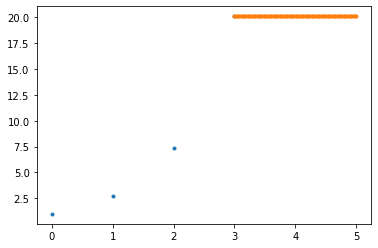

In [12]:
import numpy as np
import matplotlib.pyplot as plt
x = [0,1,2,3]
y = np.exp(np.array(x))
plt.plot(x,y,'.')
xinter = np.linspace(3,5,100)
yinter = np.interp(xinter, x, y)
plt.plot(xinter, yinter, '.')
print(yinter)
plt.show()

In [13]:
layout_test = {'width': 500}
a = widgets.Label(value="test très très long")
c = widgets.FloatSlider()
d = widgets.FloatSlider()
b = widgets.Label(value="test pas très très long")
display(widgets.HBox([a, c], box_style='success'), widgets.HBox([b, d],box_style='warning'))

HBox(box_style='success', children=(Label(value='test très très long'), FloatSlider(value=0.0)))

HBox(box_style='warning', children=(Label(value='test pas très très long'), FloatSlider(value=0.0)))